<center><a href="https://5loi.com/about_loi"><img src="images/DLI_Header.png" width="400" height="186" /></a></center>

# 1. 使用 MNIST 数据集进行图像分类

在本节中，您将进行深度学习里的“Hello World”练习：训练深度学习模型以正确地对手写体数字进行分类。

## 1.1 目标

在完成本节时，您将：
* 了解深度学习如何解决传统编程方法无法解决的问题
* 了解 [MNIST 手写体数字数据集](http://yann.lecun.com/exdb/mnist/)
* 使用 [torchvision](https://pytorch.org/vision/stable/index.html) 加载 MNIST 数据集并准备进行训练
* 创建一个简单的神经网络来执行图像分类
* 使用预先准备的 MNIST 数据集训练神经网络
* 观察经过训练的神经网络的性能

我们先来加载这个 notebook 用到的库吧：

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

我们可以通过将 [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) 设置为 `cuda` 来指定 PyTorch 使用 GPU。`torch.cuda.is_available()` 函数会确认 PyTorch 能识别到 GPU。

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

### 1.1.1 问题：图像分类

在传统的编程中，程序员可以在其代码中说明规则和条件，然后程序可以使用这些规则和条件以正确的方式执行操作。这种方法对很多的问题仍然可以很好地发挥作用。

而图像分类要求程序将以前从未见过的图像正确分类为正确的类别，使用传统编程技术几乎无法解决。程序员如何才能定义规则和条件来正确地对各种各样的图像进行分类，尤其是考虑到他们从未看过的图像？

### 1.1.2 解决方法：深度学习

在很多问题中，为使程序能正确执行所需的规则和条件，人类是难以识别和表达的，而深度学习则擅长解决这样的问题。通过用足够多的数据来训练深层神经网络，并通过训练为网络提供有关其性能的反馈，网络可以通过大量迭代来确定其自身的一组条件，以使其以正确的方式运行。

## 1.2 MNIST 数据集

在深度学习的历史当中，对 [MNIST 数据集](http://yann.lecun.com/exdb/mnist/)里的 70000 张手写体数字的图像进行 0 到 9 的正确分类是一个重大的进展。现在看来，这个任务已经不算什么了，但用 MNIST 进行图像分类已经成为深度学习的一个“Hello World”练习。

以下是 MNIST 数据集中包含的 40 张图像：

<img src="./images/mnist1.png" style="width: 600px;">

### 1.2.1 训练和测试数据及其标签

在处理用于深度学习的图像时，我们既需要图像本身（通常表示为`X`），也需要这些图像对应的正确的标签（通常表示为`Y`）。 此外，我们都需要一组`X`和`Y`以*训练*模型，然后需要单独的一组`X`和`Y`值以*测试*模型的性能。因此，我们需要将 MNIST 数据集分为4个部分：

1. `x_train`：用于训练神经网络的图像
2. `y_train`：正确的 `x_train` 图片标签，用于在训练期间评估模型的预测
3. `x_test`：单独留出来的图像，用来在训练模型后测试模型的性能
4. `y_test`：正确的 `x_test` 图像标签，用于在训练模型后评估模型的预测

准备数据的过程被称为[数据工程](https://medium.com/@rchang/a-beginners-guide-to-data-engineering-part-i-4227c5c457d7)。可以看 Jason Brownlee 的[这篇文章]()了解更多关于训练集、验证集还有测试集的区别。

### 1.2.2 将数据加载到内存中（用 TorchVision）

目前有许多[深度学习框架](https://developer.nvidia.com/deep-learning-frameworks)，每个框架都有各自的优点。在本培训中，我们将使用 [PyTorch 2](https://pytorch.org/get-started/pytorch-2.0/)，主要是 [Sequential API](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)。Sequential API 内置了很多用来构建神经网络的功能。它的[高可读性](https://blog.pragmaticengineer.com/readable-code/)和高效性使其适合在专业的任务中使用。当然 PyTorch 并非唯一的选择，您可以在启动一个深度学习项目前研究一下各种框架。

我们还会用 [TorchVision](https://pytorch.org/vision/stable/index.html) 库，它包括对[许多数据集](https://pytorch.org/vision/main/datasets.html)提供的诸多辅助功能和方法，其中就包括 MNIST 数据集。

我们将从加载 [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) 的 `train` 和 `valid` 数据集开始。

In [3]:
train_set = torchvision.datasets.MNIST("./data/", train=True, download=True)
valid_set = torchvision.datasets.MNIST("./data/", train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 262252724.95it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29224534.10it/s]


Failed to download (trying next):
HTTP Error 403: Forbidden

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 208422982.24it/s]


Failed to download (trying next):
HTTP Error 403: Forbidden

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9028686.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



上面我们说过，MNIST 数据集包含 70,000 个手写体数字的灰度图像。通过执行以下代码单元，我们可以看到 torchvision 已将 60,000 张图像分配给训练集，10,000 张分配给测试集，并且每个图像本身都是一个二维数组，尺寸为 28x28：

In [4]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

In [5]:
valid_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test

*注意：*`valid_set` 的 `Split` 值是 `Test`，但我们将在练习中将它作为验证集。要了解更多有关 `Train`，`Test`，`Valid` 数据集的信息，请看 Kili 的[这篇文章](https://kili-technology.com/training-data/training-validation-and-test-sets-how-to-split-machine-learning-data)

### 1.2.3 探索MNIST数据

我们取 `train_set` 的第一个 x, y 对观察一下数据结构：

In [6]:
x_0, y_0 = train_set[0]

In [7]:
x_0

In [8]:
type(x_0)

PIL.Image.Image

这张图到底是 5 还是一个不标准的 3？我们可以从它对应的标签中确认。

In [9]:
y_0

5

In [10]:
type(y_0)

int

## 1.3 张量（Tensor）

如果向量是一维数组，而矩阵是二维数组，那么张量就是表示任意多维度的 n 维数组。大多数现代神经网络框架都是强大的张量处理工具。

计算机屏幕上的像素就是一个三维张量的例子。不同的维度可以是宽度、高度和颜色通道（color channel）。视频游戏使用矩阵数学来计算像素值，这与神经网络计算张量的方式类似。这就是为什么 GPU 是有效的张量处理器。

我们来把图像转换成张量，好让神经网络稍后处理。TorchVision 有一个能将 [PIL 图像](https://pillow.readthedocs.io/en/stable/reference/Image.html) 转成张量的函数，使用 [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) 类：

In [11]:
trans = transforms.Compose([transforms.ToTensor()])
x_0_tensor = trans(x_0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


[PyTorch tensors](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) 有很多好用的属性和方法。我们可以验证数据类型：

In [12]:
x_0_tensor.dtype

torch.float32

我们可以验证最小值和最大值。PIL 图像的整数范围是 [0, 255]，但 [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) 类回将其转换为 [0.0, 1.0] 的浮点数范围。

In [13]:
x_0_tensor.min()

tensor(0.)

In [14]:
x_0_tensor.max()

tensor(1.)

我们还可以查看每个维度的大小。PyTorch 用的是 `C x H x W` 表示，这意味着第一个维度是颜色通道，第二个是高度，第三个是宽度。

由于这些图像是黑白的，所以只有 1 个颜色通道。图像是正方形，高度和宽度都是 28 像素：

In [15]:
x_0_tensor.size()

torch.Size([1, 28, 28])

我们还可以直接查看值：

In [16]:
x_0_tensor

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

默认情况下，张量由 [CPU](https://www.arm.com/glossary/cpu) 处理。

In [17]:
x_0_tensor.device

device(type='cpu')

把它交由 GPU 处理，可以用 `.cuda` 方法。

In [18]:
x_0_gpu = x_0_tensor.cuda()
x_0_gpu.device

device(type='cuda', index=0)

`.cuda` 方法在 PyTorch 无法识别 GPU 时会失败。为了使我们的代码更灵活，可以将张量通过 `to` 方法发送到我们在本 notebook 开头确定的 `device` 上。这样，如果有可用的 GPU，我们的代码运行速度会大大提高，没有的话代码也不会出错。

In [19]:
x_0_tensor.to(device).device

device(type='cuda', index=0)

有时候，解读如此多的数字可能会很困难。幸运的是，TorchVision 可以使用 `to_pil_image` 函数将 `C x H x W` 格式的张量转换回 PIL 图像。

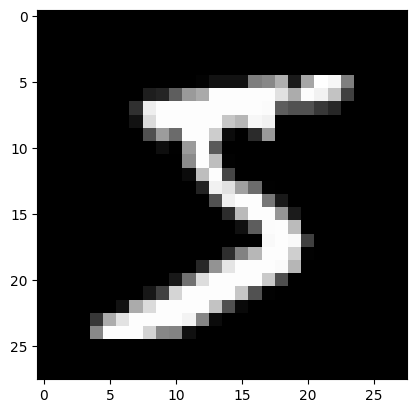

In [20]:
image = F.to_pil_image(x_0_tensor)
plt.imshow(image, cmap='gray')

## 1.4 为训练准备数据

早些时候，我们创建了一个 `trans` 变量来将图像转换为张量。[Transforms](https://pytorch.org/vision/stable/transforms.html) 是一组 torchvision 函数，可用于转换数据集。

### 1.4.1 变化（Transforms）

[Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Compose.html#torchvision.transforms.v2.Compose) 函数将一系列变换组合在一起。我们将在后面的 notebook 中学习更多关于变换的内容，这里先把 `trans` 的定义再展示一遍。

In [21]:
trans = transforms.Compose([transforms.ToTensor()])

之前，我们只对一个值应用了 `trans`。我们可以通过多种方式将一系列变换应用于数据集。其中一种方法是将其设置为数据集的 `transform` 变量。

In [22]:
train_set.transform = trans
valid_set.transform = trans

### 1.4.2 数据加载器（DataLoaders）

如果我们的数据集是一副卡，那么 [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) 就定义了我们如何从这副牌中抽卡来训练 AI 模型。我们可以一次性将整个数据集展示给我们的模型。这不仅需要大量的计算资源，而且[研究表明](https://arxiv.org/pdf/1804.07612)使用较小的数据批次（batch）对模型训练更有效。

例如，如果我们的 `batch_size` 是 32，我们将洗牌并抽取 32 张卡片来训练我们的模型。由于模型在验证时不进行学习，因此不需要洗牌，但我们仍然会使用 `batch_size` 以防止内存错误。

批大小是模型开发者决定的，最佳值取决于具体的问题。研究表明，对于许多机器学习问题 32 或 64 就足够了，这也是一些机器学习框架的默认值，因此我们在这就用 32。

In [23]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 1.5 创建模型

准备好训练数据之后，现在该来创建模型了！神经网络由多个层组成，每一层在将数据传递到下一层之前对接收到的数据执行数学运算。首先，我们将创建一个由 4 个组件组成的 “Hello World” 级别的模型：

1. 一个 [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) 层，用于将 n 维数据转换为向量。
2. 输入层，即第一层神经元
3. 隐藏层，即输入和输出之间“隐藏”的另一层神经元
4. 输出层，即最后一组神经元，返回模型的最终预测结果

关于这些层的更多信息，可以参考 Sarita 的[这篇博客文章](https://medium.com/@sarita_68521/basic-understanding-of-neural-network-structure-eecc8f149a23)。

让我们创建一个 `layers` 变量来保存我们的层列表。

In [24]:
layers = []
layers

[]

### 1.5.1 展平图片

当我们之前查看数据的形状时，我们看到图像有 3 个维度：`C x H x W`。将图像展平意味着将所有这些维度合并成 1 个维度。假设我们有一个如下所示的张量。尝试运行代码单元,看看它在展平前后的样子。

In [25]:
test_matrix = torch.tensor(
    [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]
)
test_matrix

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [26]:
nn.Flatten()(test_matrix)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

什么都没发生？这是因为神经网络期望接收一批数据。目前，Flatten 层看到的是三个向量，而不是一个二维矩阵。为了解决这个问题，我们可以通过添加一对额外的方括号来"批量化"我们的数据。由于 `test_matrix` 现在是一个张量，我们可以使用下面的简写方式来实现这一点。`None` 可以添加一个新的维度，`:` 可以选中张量中的所有数据。

In [27]:
batch_test_matrix = test_matrix[None, :]
batch_test_matrix

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [28]:
nn.Flatten()(batch_test_matrix)

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

顺序是很重要的！如果反过来的话就会变成这样：

In [29]:
nn.Flatten()(test_matrix[:, None])

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

现在我们有了 `Flatten` 层，加到我们的 `layers` 列表中吧。

In [30]:
layers = [
    nn.Flatten()
]
layers

[Flatten(start_dim=1, end_dim=-1)]

### 1.5.2 输入层

我们的第一层神经元将展平的图像连接到模型的其余部分。为此，我们将使用 [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) 层。这一层将是*密集连接*的，意味着其中的每个神经元及其权重都会影响下一层的每个神经元。

为了创建这些权重，PyTorch 需要知道输入的大小以及我们想要创建多少个神经元。
由于我们已经将图像展平，输入的大小就是通道数、垂直像素数和水平像素数的乘积。

In [31]:
input_size = 1 * 28 * 28

"数据科学"中"科学"主要就体现在选择正确的神经元数量上，因为这涉及捕捉数据集的统计复杂性。我们先使用 512 个神经元。稍后您可以尝试调整这个数值，看看它如何影响训练，慢慢理解这个数字的含义。

我们稍后会学习更多关于激活函数的知识，但现在我们将使用 [relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) 激活函数。简而言之，它将帮助我们的网络学习如何对数据做出比仅基于某些严格线性函数更复杂的猜测。

In [32]:
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU()]

### 1.5.3 隐藏层

现在，我们将添加一个额外的密集连接层。我们将在下一节讨论为什么添加另一组神经元可以帮助提高学习效果。就像输入层需要知道传递给它的数据的形状一样，隐藏层的 [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) 也需要知道传递给它的数据的形状。前一层的每个神经元将计算一个数值，因此进入隐藏层的输入数量与前一层的神经元数量相同。

In [33]:
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU()  # Activation for hidden
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU()]

### 1.5.4 输出层

最后，我们将添加一个输出层。在这种情况下，由于网络需要猜测图像属于 10 个可能类别中的哪一个，因此将有 10 个输出。每个输出都分配一个神经元。输出神经元的值相比其它神经元越大，模型就越倾向预测输入的图像属于该神经元分配的类别。

我们不会将 `relu` 函数设置给输出层。下一节中我们会应用一个`损失函数`。

In [34]:
n_classes = 10

layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

### 1.5.5 编译模型

[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) 模型期望接收一个参数序列，而不是一个列表，因此我们可以使用 [* operator](https://docs.python.org/3/reference/expressions.html#expression-lists) 将层列表解包成一个序列。打印模型来验证这些层是否正确加载了。

In [35]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

与张量类似，当模型首次初始化时，它将在 CPU 上处理。要使用 GPU 进行处理，我们可以用 `to(device)`。

In [36]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

可以通过检查模型参数所在的设备来确认模型处于哪个设备。更多信息请查看这个 [stack overflow](https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently) 帖子。

In [37]:
next(model.parameters()).device

device(type='cuda', index=0)

[PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) 引入了高性能编译特性。可以从[这里](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html)了解更多。

In [38]:
model = torch.compile(model)

## 1.6 训练模型

现在，我们已经准备好了训练数据和测试数据，以及一个模型，现在该使用训练数据训练模型，并使用验证集来验证了。

“用数据训练模型”通常也称为“使模型拟合数据”。后一种表达方式突显了模型里的权重随时间而变化，以使模型更准确地理解提供给它的数据。

### 1.6.1 损失和优化

就像老师给学生打分一样，我们需要为模型提供一个函数来对其答案进行评分。这称为`损失函数`。我们将使用一种名为 [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) 的损失函数，它用于评估模型是否从一组类别中预测了正确的类别。

In [39]:
loss_function = nn.CrossEntropyLoss()

接下来，我们为模型选择一个`优化器`。如果`损失函数`提供了一个评分，优化器则告诉模型如何从这个评分中学习，以便下次表现得更好。

In [40]:
optimizer = Adam(model.parameters())

### 1.6.2 计算准确率

虽然损失函数的结果能有效地帮助模型学习，但这些值对人类来说可能难以理解。这就是为什么数据科学家通常会给出其它指标，如准确率。

为了精确地计算准确率，我们应该比较正确分类的数量与总预测数量。由于我们以批次的方式向模型展示数据，因此准确率也可以按批来计算。

首先，总预测数量与我们数据集的大小相同。将数据集的大小设为 `N`，`n` 作为`批大小`。

In [41]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

接下来，我们将创建一个函数来计算每个批次的准确率。其结果是总准确率的一部分，因此将每个批次的准确率相加就可以得到总准确率。

In [42]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

### 1.6.3 训练函数

现在所有的部分都齐了。下方代码是我们根据训练数据定义的训练模型的函数。稍后将更详细地逐行解释代码，现在请花点时间查看其结构。您能认出我们之前创建的变量吗？

In [43]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### 1.6.4 验证函数

同样，这段代码用于验证模型在未训练数据上的表现。你能发现与 `train` 函数的一些区别吗？

In [44]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### 1.6.5 训练循环

为了查看模型的进展情况，我们将在训练和验证之间交替进行。就像学生可能需要多次通过他们的卡来学习所有概念一样，模型也会多次通过训练数据来获得更好的理解。

一个 `epoch` 是对整个数据集的一次完整遍历。让我们训练和验证模型 5 个 epoch，看看它的学习情况。

In [45]:
epochs = 5

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 377.2585 Accuracy: 0.9388
Valid - Loss: 29.5635 Accuracy: 0.9698
Epoch: 1
Train - Loss: 157.9884 Accuracy: 0.9739
Valid - Loss: 23.8644 Accuracy: 0.9751
Epoch: 2
Train - Loss: 109.3676 Accuracy: 0.9811
Valid - Loss: 25.7610 Accuracy: 0.9759
Epoch: 3
Train - Loss: 81.7273 Accuracy: 0.9863
Valid - Loss: 26.5582 Accuracy: 0.9769
Epoch: 4
Train - Loss: 67.3491 Accuracy: 0.9885
Valid - Loss: 20.5775 Accuracy: 0.9817


我们已经接近 100% 了！让我们测试原始样本来验证这一点。可以像使用函数一样使用我们的模型：

In [46]:
prediction = model(x_0_gpu)
prediction

tensor([[-20.7059, -11.1425, -16.5012,   5.0466, -25.4608,  20.1927, -21.7422,
         -14.3709, -14.6015,  -7.5765]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)

应该有十个数字，每个数字对应一个不同的输出神经元。感谢我们良好的数据结构，每个数字的索引都与相应的手写数字匹配。第 0 个索引是对手写数字 0 的预测，第 1 个索引是对手写数字 1 的预测，依此类推。

我们可以使用 `argmax` 函数来找到最大值的索引。

In [47]:
prediction.argmax(dim=1, keepdim=True)

tensor([[5]], device='cuda:0')

它预测对了么？

In [48]:
y_0

5

## 1.7 总结

模型表现得相当不错！准确率迅速接近 100%，验证准确率也是如此。我们现在已经有一个可以准确检测和分类手写图像的模型了。

下一步是使用这个模型来分类新的、尚未见过的手写图像。这称为[推理](https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/)。我们将在后续练习中探索推理过程。

值得花点时间来欣赏一下我们所做的工作。历史上，为执行这类任务而构建的专家系统非常复杂，人们花费了整个职业生涯来构建它们（请查看[官方 MNIST 页面](http://yann.lecun.com/exdb/mnist/)上的参考资料以及各个年份的里程碑）。

MNIST 不仅因其对计算机视觉的历史影响而有用，它还是一个很好的[基准（benchmark）](http://www.cs.toronto.edu/~serailhydra/publications/tbd-iiswc18.pdf)和调试工具。使用新的机器学习架构时遇到困难了么？用 MNIST 测试一下。如果它没法在这个数据集上学习，那么它很可能也不能在更复杂的图像和数据集上学习。

### 1.7.1 清理显存

继续前，请执行以下单元清理 GPU 显存。转至下一 notebook 之前需要执行此操作。

In [49]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 1.7.2 下一步

在本节中，您学习了如何构建和训练用于图像分类的一个简单的神经网络。在下一节中，您将构建自己的神经网络并执行数据准备，以解决其他图像分类问题。